# Melanoma Cancer Classification (Benign - Malignant)
### The goal of this project is to determine weather the person has Melanoma or not using only the image input

# Data
## 13900 images 224 x 244
### Training data - 11879 images in total
 - 6289 Malignant images
 - 5590 Benign images
### Testing Data - 2000 images in total
 - 1000 images for Malignant
 - 1000 images for Bengin in a total of 2000 images


Source: Kaggle

Link: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

In [4]:
"""
source_path = r"C:\Users\D E L L\Desktop\Deep Learning Project\test"
output_path = r"C:\Users\D E L L\Desktop\Deep Learning Project\cancer_data_split"

for split in ['val', 'test']:
    split_path = os.path.join(output_path, split)
    os.makedirs(split_path, exist_ok=True)

for disease_folder in os.listdir(source_path):
    disease_path = os.path.join(source_path, disease_folder)
    if not os.path.isdir(disease_path):
        continue
    
    images = [img for img in os.listdir(disease_path) if img.endswith(('png', 'jpg', 'jpeg'))]
    val_imgs, test_imgs = train_test_split(images, test_size=0.5, random_state=42)
    
    for split, split_imgs in zip(['val', 'test'], [val_imgs, test_imgs]):
        split_dir = os.path.join(output_path, split, disease_folder)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(disease_path, img), os.path.join(split_dir, img))

print("Data splitting completed.")
"""

Data splitting completed.


# Creating the Utility class

In [2]:
class Utility:
    def __init__(self, train_dir, val_dir, test_dir, img_height=32, img_width=32, batch_size=32, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip

        self.train_datagen = ImageDataGenerator(
            rescale=1./255,  # Normalize pixel values
            rotation_range=self.rotation_range,
            width_shift_range=self.width_shift_range,
            height_shift_range=self.height_shift_range,
            shear_range=self.shear_range,
            zoom_range=self.zoom_range,
            horizontal_flip=self.horizontal_flip,
            fill_mode='nearest'
        )

        self.val_datagen = ImageDataGenerator(rescale=1./255)
        self.test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
utility = Utility(
    train_dir=r"C:\Users\D E L L\Desktop\Deep Learning Project\cancer_data_split\train",
    val_dir=r"C:\Users\D E L L\Desktop\Deep Learning Project\cancer_data_split\val",
    test_dir=r"C:\Users\D E L L\Desktop\Deep Learning Project\cancer_data_split\test"
)

In [4]:
def analyze_directories(directory):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            print(f"Class '{class_name}': {len(os.listdir(class_path))} images")
            
print("Training Data:")
analyze_directories(utility.train_dir)

print("\nValidation Data:")
analyze_directories(utility.val_dir)

print("\nTest Data:")
analyze_directories(utility.test_dir)


Training Data:
Class 'Benign': 6289 images
Class 'Malignant': 5590 images

Validation Data:
Class 'Benign': 500 images
Class 'Malignant': 500 images

Test Data:
Class 'Benign': 500 images
Class 'Malignant': 500 images


Training Class Distribution:
           Count
Benign      6289
Malignant   5590


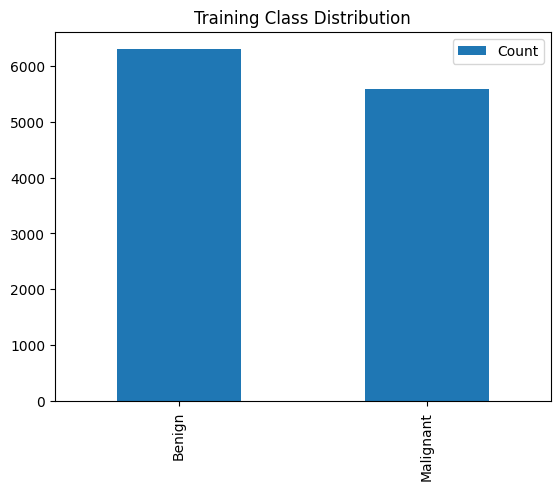

In [5]:
def class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])

train_distribution = class_distribution(utility.train_dir)
val_distribution = class_distribution(utility.val_dir)
test_distribution = class_distribution(utility.test_dir)

print("Training Class Distribution:")
print(train_distribution)

train_distribution.plot(kind='bar', title="Training Class Distribution")
plt.show()

### Creating the training, validation and testing image generators

In [6]:
def create_generators(self):
    self.train_generator = self.train_datagen.flow_from_directory(
        self.train_dir,
        target_size=(self.img_height, self.img_width),
        batch_size=self.batch_size,
        color_mode='rgb',
        class_mode='categorical'
    )

    self.val_generator = self.val_datagen.flow_from_directory(
        self.val_dir,
        target_size=(self.img_height, self.img_width),
        batch_size=self.batch_size,
        color_mode='rgb',
        class_mode='categorical'
    )

    self.test_generator = self.test_datagen.flow_from_directory(
        self.test_dir,
        target_size=(self.img_height, self.img_width),
        batch_size=self.batch_size,
        color_mode='rgb',
        class_mode='categorical'
    )
    print("Generators Created")
Utility.create_generators = create_generators

### Building the model architecture

In [7]:
def build_model(self):
    model = Sequential([
        Input(shape=(self.img_height, self.img_width, 3)),
        Conv2D(64, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),

        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model
    print("Model built successfully")
Utility.build_model = build_model

### Compiling the model

In [8]:
def compile_model(self, model, learning_rate=0.001):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
    print("Model Compiled successfully")
Utility.compile_model = compile_model

### Training the model

In [9]:
def train_model(self, model, epochs=20):
    history = model.fit(
        self.train_generator,
        epochs=epochs,
        validation_data=self.val_generator
    )
    return history
    print("Model trained successfully")
Utility.train_model = train_model

### Model Evaluation

In [37]:
def evaluate_model(self, model):
    test_loss, test_acc = model.evaluate(self.test_generator)

    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_acc)

    return test_loss, test_acc
Utility.evaluate_model = evaluate_model

# Creating the Helper class

In [39]:
class Helper:
    def __init__(self, utility):
        self.utility = utility

    def run(self, learning_rate=0.001, epochs=20, batch_size=32, img_height=32, img_width=32, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True):
        self.utility.__init__(
            self.utility.train_dir,
            self.utility.val_dir,
            self.utility.test_dir,
            img_height=img_height,
            img_width=img_width,
            batch_size=batch_size,
            rotation_range=rotation_range,
            width_shift_range=width_shift_range,
            height_shift_range=height_shift_range,
            shear_range=shear_range,
            zoom_range=zoom_range,
            horizontal_flip=horizontal_flip
        )

        self.utility.create_generators()
        model = self.utility.build_model()
        model = self.utility.compile_model(model, learning_rate=learning_rate)
        history = self.utility.train_model(model, epochs=epochs)
        test_loss, test_acc = self.utility.evaluate_model(model)

        return model, test_loss, test_acc

## Running Scenario 1

In [40]:
helper = Helper(utility)
scenario_1, loss_1, acc_1 = helper.run(
    learning_rate=0.0005,
    epochs=10,
    batch_size=64,
    img_height=32,
    img_width=32,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

Found 11879 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Generators Created
Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.7037 - loss: 0.5643 - val_accuracy: 0.7170 - val_loss: 0.6406
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.7678 - loss: 0.4607 - val_accuracy: 0.6270 - val_loss: 0.6823
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.7731 - loss: 0.4400 - val_accuracy: 0.6360 - val_loss: 0.8193
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.7805 - loss: 0.4311 - val_accuracy: 0.8820 - val_loss: 0.3462
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.8037 - loss: 0.4184 - val_accuracy: 0.8530 - val_loss: 0.3434
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.8006 - loss: 0.4084 - val_accuracy: 0.6820 - val_loss: 0.5717
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0

In [41]:
#model.save("model.h5")

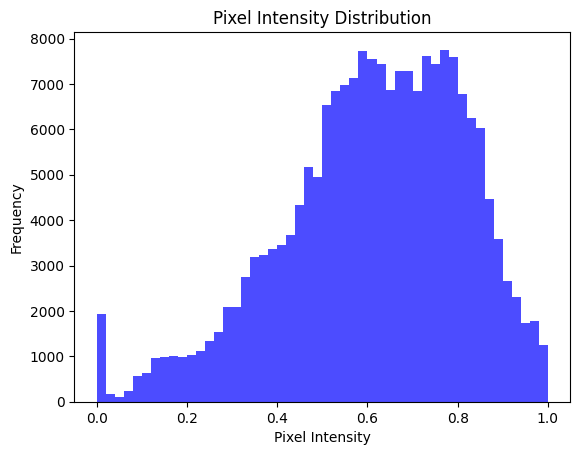

In [42]:
def plot_pixel_histogram(generator):
    x_batch, y_batch = next(generator)
    plt.hist(x_batch.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

plot_pixel_histogram(utility.train_generator)

In [43]:
helper = Helper(utility)
scenario_2, loss_2, acc_2 = helper.run(
    learning_rate=0.0005,
    epochs=10,
    batch_size=32,
    img_height=8,
    img_width=8,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

Found 11879 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Generators Created
Epoch 1/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.6935 - loss: 0.5744 - val_accuracy: 0.7230 - val_loss: 0.5385
Epoch 2/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7598 - loss: 0.5006 - val_accuracy: 0.7780 - val_loss: 0.4864
Epoch 3/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8035 - loss: 0.4478 - val_accuracy: 0.8740 - val_loss: 0.3759
Epoch 4/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8081 - loss: 0.4322 - val_accuracy: 0.8510 - val_loss: 0.3694
Epoch 5/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8150 - loss: 0.4217 - val_accuracy: 0.7630 - val_loss: 0.5212
Epoch 6/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8170 - loss: 0.4104 - val_accuracy: 0.7400 - val_loss: 0.5251
Epoch 7/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8172 -

# Pretrained - VGG16

In [44]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'C:/Users/D E L L/Desktop/Deep Learning Project/cancer_data_split/train',
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    'C:/Users/D E L L/Desktop/Deep Learning Project/cancer_data_split/val',
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    'C:/Users/D E L L/Desktop/Deep Learning Project/cancer_data_split/test',
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


vgg_frozen_loss, vgg_frozen_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

for layer in base_model.layers[-5:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

vgg_unfrozen_loss, vgg_unfrozen_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#model.save('fine_tuned_cancer_model.h5')


Found 11879 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.7835 - loss: 0.4539 - val_accuracy: 0.7860 - val_loss: 0.4218
Epoch 2/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.8227 - loss: 0.3867 - val_accuracy: 0.7800 - val_loss: 0.4300
Epoch 3/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8348 - loss: 0.3666 - val_accuracy: 0.8090 - val_loss: 0.3883
Epoch 4/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.8345 - loss: 0.3568 - val_accuracy: 0.7960 - val_loss: 0.4001
Epoch 5/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.8380 - loss: 0.3533 - val_accuracy: 0.8180 - val_loss: 0.3672
Epoch 6/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8341 - loss: 0.3487 - val_accuracy: 0.7840 - val_loss: 0.4356
Epoch 7/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8385 - loss: 0.3488 - val

# Pertrained - ViT

In [46]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    'C:/Users/D E L L/Desktop/Deep Learning Project/cancer_data_split/train',
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    'C:/Users/D E L L/Desktop/Deep Learning Project/cancer_data_split/val',
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    'C:/Users/D E L L/Desktop/Deep Learning Project/cancer_data_split/test',
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

vit_frozen_loss, vit_frozen_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

for layer in base_model.layers[-5:]:  # Unfreeze the last 5 layers
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

vit_unfrozen_loss, vit_unfrozen_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#model.save('fine_tuned_cancer_model.h5')


Found 11879 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.7840 - loss: 0.4561 - val_accuracy: 0.8110 - val_loss: 0.4162
Epoch 2/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.8182 - loss: 0.3797 - val_accuracy: 0.7540 - val_loss: 0.4517
Epoch 3/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.8339 - loss: 0.3630 - val_accuracy: 0.7700 - val_loss: 0.4345
Epoch 4/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.8364 - loss: 0.3573 - val_accuracy: 0.7930 - val_loss: 0.3940
Epoch 5/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.8412 - loss: 0.3557 - val_accuracy: 0.8270 - val_loss: 0.3750
Epoch 6/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.8389 - loss: 0.3503 - val_accuracy: 0.7980 - val_loss: 0.3794
Epoch 7/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.8428 - loss: 0.3396 - val

In [48]:
models = ['Scenario 1', 'Scenario 2', 'VGG Frozen', 'VGG Unfrozen', 'ViT Frozen', 'ViT Unfrozen']
accuracies = [acc_1, acc_2, vgg_frozen_accuracy, vgg_unfrozen_accuracy, vit_frozen_accuracy, vit_unfrozen_accuracy]
losses = [loss_1, loss_2, vgg_frozen_loss, vgg_unfrozen_loss, vit_frozen_loss, vit_unfrozen_loss]

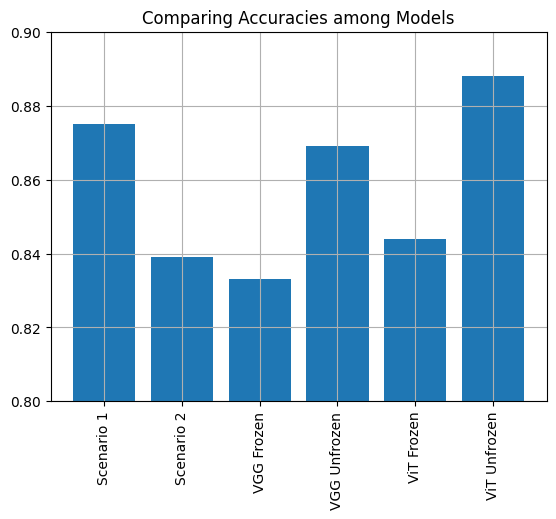

In [51]:
plt.bar(models, accuracies)
plt.grid()
plt.title("Comparing Accuracies among Models")
plt.ylim(0.8, 0.9)
plt.xticks(rotation=90)
plt.show()

In [ ]:
"""
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.0017942802514880896).astype(int).flatten()

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 10: Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive']))


print("First 10 True Labels:", true_labels[:10])
print("First 10 Predicted Probabilities:", predictions[:10])
print("First 10 Predicted Labels:", predicted_labels[:10])


manual_accuracy = np.mean(true_labels == predicted_labels)
print(f"Manual Accuracy: {manual_accuracy * 100:.2f}%")

from sklearn.metrics import roc_curve

# Get true labels and predicted probabilities
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator).flatten()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Recalculate predicted labels using the optimal threshold
y_pred_labels = (y_pred_probs > optimal_threshold).astype(int)
"""